<a href="https://colab.research.google.com/github/skumarudel/DSPS_SKumar/blob/master/HW9/DPS2021_deepdream_SKumar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# By Sajan for assignment number 9
# DeepDreaming with TensorFlow


#modified by FBB (@fedhere) for UD DSPS 2019 class last updated for DSPS 2021 including upgrading to python3 and current version of TF

### ___Alex Mordvintsev___

This notebook produces DeepDream images from user-supplied photos using Google's pretrained Inception neural network. It can be used as a starting point for further exploration in visualizing convolutional neural networks.

###  Load the model graph

The pretrained Inception network can be downloaded [here](https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip). This next cell downloads the file automatically and unpacks it locally to the Colab kernel. We can the load the contained model file  'tensorflow_inception_graph.pb' in the cell below.

In [1]:
!wget -nc --no-check-certificate https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip && unzip -n inception5h.zip

from io import BytesIO
from IPython.display import clear_output, Image, display
import numpy as np
import PIL.Image
import tensorflow as tf
import pylab as pl
from __future__ import print_function

model_fn = 'tensorflow_inception_graph.pb'

# creating TensorFlow session and loading the model
graph = tf.Graph()
sess = tf.compat.v1.InteractiveSession(graph=graph)
with tf.compat.v2.io.gfile.GFile(model_fn, 'rb') as f:

    graph_def = tf.compat.v1.GraphDef()   # -> instead of tf.GraphDef() 
    graph_def.ParseFromString(f.read())
t_input = tf.compat.v1.placeholder(np.float32, name='input') # define the input tensor
imagenet_mean = 117.0
t_preprocessed = tf.expand_dims(t_input-imagenet_mean, 0)
tf.import_graph_def(graph_def, {'input':t_preprocessed})

def T(layer):
    '''Helper for getting layer output tensor'''
    return graph.get_tensor_by_name("import/%s:0"%layer)

--2021-11-29 01:04:47--  https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.132.128, 74.125.201.128, 74.125.69.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.132.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49937555 (48M) [application/zip]
Saving to: ‘inception5h.zip’

inception5h.zip     100%[===================>]  47.62M  83.6MB/s    in 0.6s    

2021-11-29 01:04:48 (83.6 MB/s) - ‘inception5h.zip’ saved [49937555/49937555]

Archive:  inception5h.zip
  inflating: imagenet_comp_graph_label_strings.txt  
  inflating: tensorflow_inception_graph.pb  
  inflating: LICENSE                 


make sure you are running on the GPUs - on the notebook menu go to 

Runtime\-\>Change Runtime type




In [2]:
!wget https://github.com/fedhere/DSPS_FBianco/raw/master/HW9/runtime.png

--2021-11-29 01:06:32--  https://github.com/fedhere/DSPS_FBianco/raw/master/HW9/runtime.png
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/fedhere/DSPS_FBianco/master/HW9/runtime.png [following]
--2021-11-29 01:06:33--  https://raw.githubusercontent.com/fedhere/DSPS_FBianco/master/HW9/runtime.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50464 (49K) [image/png]
Saving to: ‘runtime.png’

runtime.png         100%[===================>]  49.28K  --.-KB/s    in 0.008s  

2021-11-29 01:06:33 (5.75 MB/s) - ‘runtime.png’ saved [50464/50464]



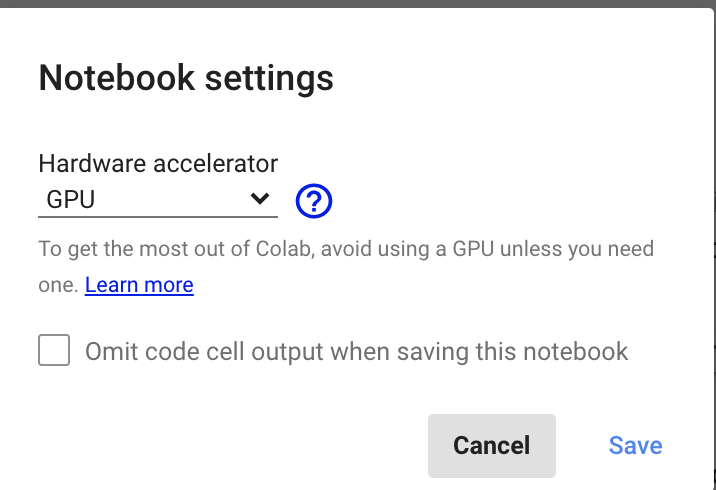

In [3]:
from IPython.display import Image
Image(filename='runtime.png') 

In [4]:
def showarray(a, fmt='jpeg'):
    #if a is > 3 axis cut the last one assuming its alpha-transparency 
    if a.shape[-1] == 4:
      a = a[:,:,:3]
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))
    


# Task 1: Create a random noise "image": 
an array of 300x300 pixels and 3 color channels (RGB). Fill it in with random noise but make sure the values are Unsigned integer 8bit type (np.unit8) and contained between 0 and 255. This is how a jpg image would be encoded in python and both pylab and this base code require this encoding for the image.  This can be achieved by generating random uniform noise (between 0 and 1) and convert it to 0-255 by multiplication, then convert the data type

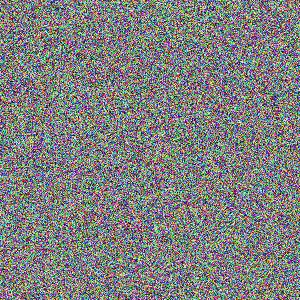

In [5]:
rnd = (np.random.rand(300*300*3).reshape(300,300,3)*255).astype(np.uint8)
showarray(rnd)


In [6]:
# These parameters let us control the strenth of the deepdream.
octave_n = 4
octave_scale = 1.4
iter_n = 10
strength = 200

# Helper function that uses TensorFlow to resize an image
def resize(img, new_size):
    return sess.run(tf.compat.v1.image.resize_bilinear(img[np.newaxis,:], new_size))[0]

# Apply gradients to an image in a seires of tiles
def calc_grad_tiled(img, t_grad, tile_size=256):
    '''Random shifts are applied to the image to blur tile boundaries over
    multiple iterations.'''
    h, w = img.shape[:2]
    sx, sy = np.random.randint(tile_size, size=2)
    # We randomly roll the image in x and y to avoid seams between tiles.
    img_shift = np.roll(np.roll(img, sx, 1), sy, 0)
    grad = np.zeros_like(img)
    for y in range(0, max(h-tile_size//2, tile_size),tile_size):
        for x in range(0, max(w-tile_size//2, tile_size),tile_size):
            sub = img_shift[y:y+tile_size,x:x+tile_size]
            g = sess.run(t_grad, {t_input:sub})
            grad[y:y+tile_size,x:x+tile_size] = g
    imggrad = np.roll(np.roll(grad, -sx, 1), -sy, 0)
    # Add the image gradient to the image and return the result
    return img + imggrad*(strength * 0.01 / (np.abs(imggrad).mean()+1e-7))

# Applies deepdream at multiple scales
def render_deepdream(t_obj, input_img, show_steps = True):
    # Collapse the optimization objective to a single number (the loss)
    t_score = tf.reduce_mean(t_obj)
    # We need the gradient of the image with respect to the objective
    t_grad = tf.gradients(t_score, t_input)[0]

    # split the image into a number of octaves (laplacian pyramid)
    img = input_img
    octaves = []
    for i in range(octave_n-1):
        lo = resize(img, np.int32(np.float32(img.shape[:2])/octave_scale))
        octaves.append(img-resize(lo, img.shape[:2]))
        img = lo

    # generate details octave by octave
    for octave in range(octave_n):
        if octave>0:
            hi = octaves[-octave]
            img = resize(img, hi.shape[:2])+hi
        for i in range(iter_n):
            img = calc_grad_tiled(img, t_grad)
        if show_steps:
            clear_output()
            showarray(img)
    return img

# Task 2 start a deep dream : 

Adjust the sliders to change the strength of the deep dream, and how many scales it is applied over and until you obtain a "phsychadelic" result that you like

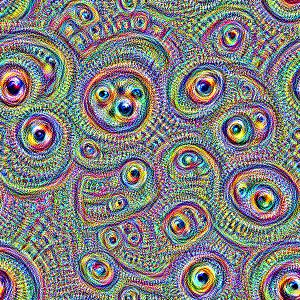

In [9]:
octave_n = 3 #@param {type:"slider", max: 10}
octave_scale = 1.4 #@param {type:"number"}
iter_n = 35 #@param {type:"slider", max: 50}
strength = 221 #@param {type:"slider", max: 1000}
layer = "mixed4a"  #@param ["mixed3a", "mixed3b", "mixed4a", "mixed4c", "mixed5a"]

final = render_deepdream(tf.square(T(layer)), rnd)


 # Task 3 pull each layer: 
 look at the bottom diagram that shows the architecture of the layer. Plot each relevant layer: the layers that start with "mixed"  

In [10]:
layers = [op.name for op in graph.get_operations() if op.type=='Conv2D' and 'import/' in op.name]
feature_nums = [int(graph.get_tensor_by_name(name+':0').get_shape()[-1]) for name in layers]

print('Number of layers', len(layers))
print('Total number of feature channels:', sum(feature_nums))

for layer in layers:
  print('Layer:', layer)

Number of layers 59
Total number of feature channels: 7548
Layer: import/conv2d0_pre_relu/conv
Layer: import/conv2d1_pre_relu/conv
Layer: import/conv2d2_pre_relu/conv
Layer: import/mixed3a_1x1_pre_relu/conv
Layer: import/mixed3a_3x3_bottleneck_pre_relu/conv
Layer: import/mixed3a_3x3_pre_relu/conv
Layer: import/mixed3a_5x5_bottleneck_pre_relu/conv
Layer: import/mixed3a_5x5_pre_relu/conv
Layer: import/mixed3a_pool_reduce_pre_relu/conv
Layer: import/mixed3b_1x1_pre_relu/conv
Layer: import/mixed3b_3x3_bottleneck_pre_relu/conv
Layer: import/mixed3b_3x3_pre_relu/conv
Layer: import/mixed3b_5x5_bottleneck_pre_relu/conv
Layer: import/mixed3b_5x5_pre_relu/conv
Layer: import/mixed3b_pool_reduce_pre_relu/conv
Layer: import/mixed4a_1x1_pre_relu/conv
Layer: import/mixed4a_3x3_bottleneck_pre_relu/conv
Layer: import/mixed4a_3x3_pre_relu/conv
Layer: import/mixed4a_5x5_bottleneck_pre_relu/conv
Layer: import/mixed4a_5x5_pre_relu/conv
Layer: import/mixed4a_pool_reduce_pre_relu/conv
Layer: import/mixed4b_1

## Earlier layer display

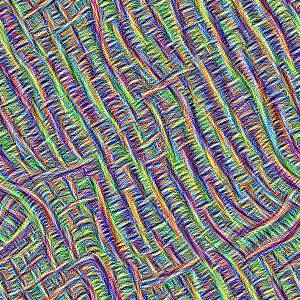

In [13]:
layer = "mixed3b_5x5_pre_relu"
final = render_deepdream(tf.square(T(layer)), rnd)

## Deeper layer display

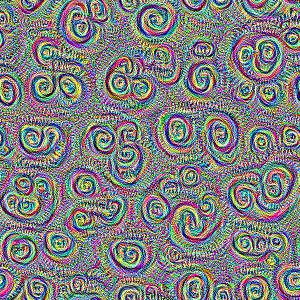

In [11]:
layer = "head0_bottleneck_pre_relu"
final = render_deepdream(tf.square(T(layer)), rnd)

# Task 4:  Qalitatively describe
based on your understanding and reading, why the layers show different features and what it the "kind" of features extracted in the earler layers vs the later ones.


**Earlier layers show edges, lines and texture, whereas the later layers (deeper layers) show higher level feature such as eyes, faces** 

# Task 5: Load your chosen image 
must be at least 600 pixels in each size

In [21]:
from google.colab import files
uploaded = files.upload()

Saving IC443_image.jpg to IC443_image.jpg


In [22]:

if type(uploaded) is not dict: uploaded = uploaded.files  ## Deal with filedit versions
file_contents = uploaded[list(uploaded.keys())[0]]


In [23]:
tf.io.decode_image(file_contents)

<tf.Tensor 'decode_image_2/DecodeImage:0' shape=<unknown> dtype=uint8>

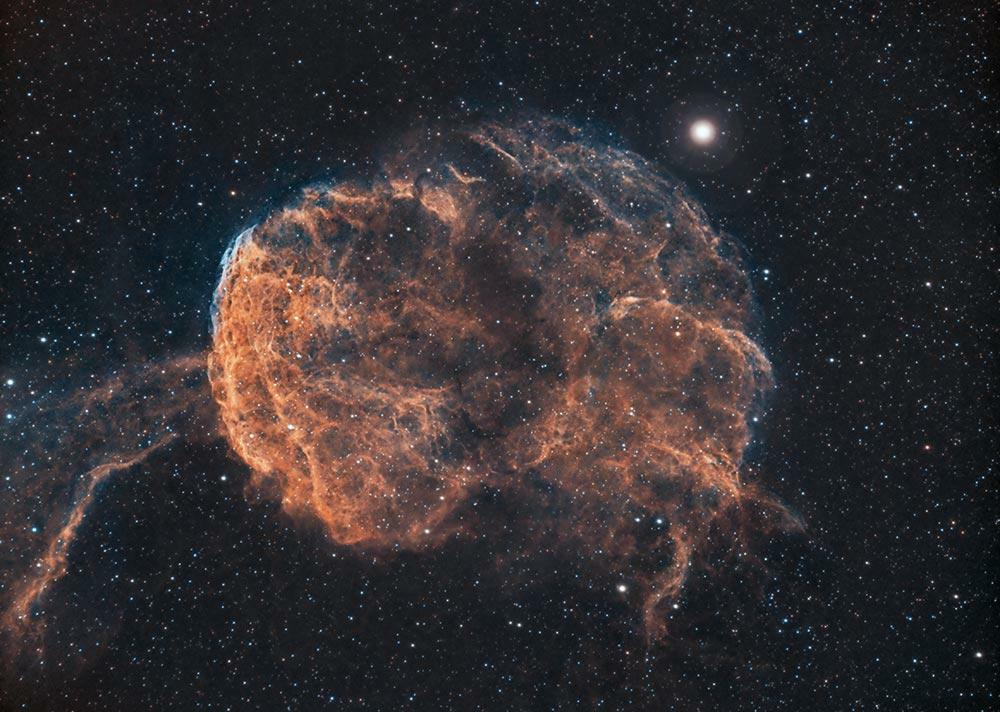

In [24]:
img0 = sess.run(tf.io.decode_image(file_contents))
showarray(img0)


# Task 6: shrink it to 600 pixels along the x axis by subsampling 


In [25]:
img0.shape

(712, 1000, 3)

In [26]:
basewidth = 600
img1 = img0.copy()

if img0.shape[0] > basewidth:
  step = int(float(img0.shape[0] / basewidth))
  if img0.shape[-1] == 4:
    img0 = img0[:,:,:3]

  img1 = img0.copy()
  img1 = img1[::step]
elif img0.shape[0] < basewidth:
  import scipy
  img1 = scipy.ndimage.zoom(img0, zoom=(2, 1,1), order=1)





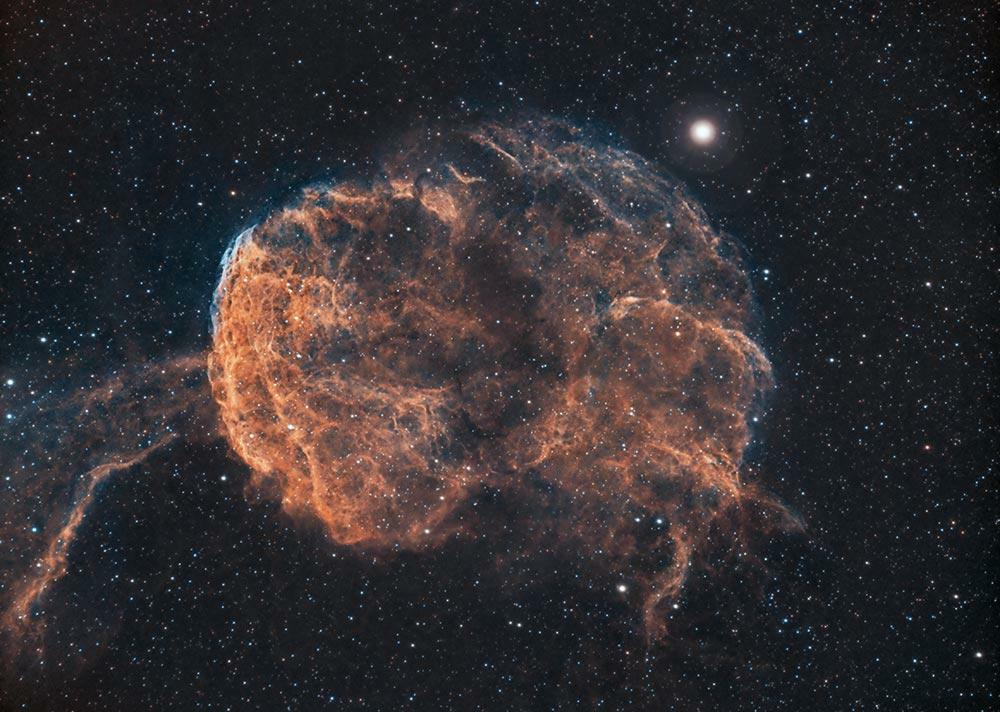

In [27]:
#img0 = sess.run(tf.io.decode_image(file_contents))
showarray(img1)

# Task 7: Repeat step 4, DeepDream, with your image. 
Save the layer you like. Upload tha original and modified image to the readme file of your DSPS repo



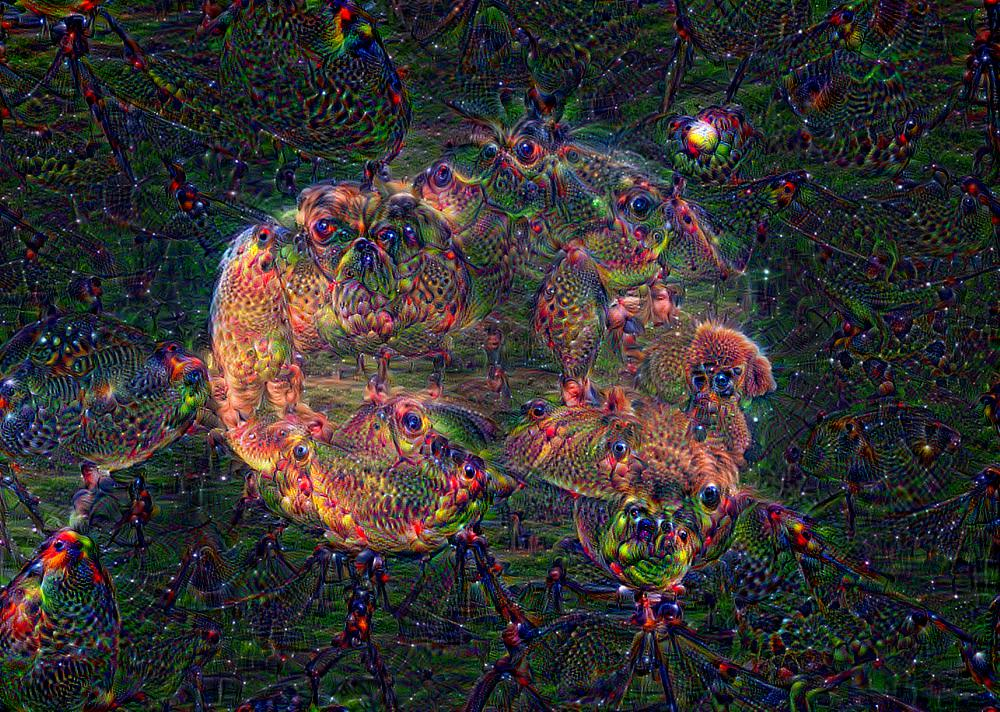

In [33]:
layer = "mixed5b_pool_reduce_pre_relu"
final = render_deepdream(tf.square(T(layer)), img1)

# Task 8: Answer: Are there "animals" in your image? why? (there should be)


**I am able to see the images of animals in the image i chose with the deepest layer. However, i can only see some furs, eyes in the image.**

### Further reading for the curious

 *   Original [DeepDream (Inceptionism) blog post](https://research.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html)
 *   [Original DeepDream algorithm](https://github.com/google/deepdream/blob/master/dream.ipynb) with Caffe

## Optional: Diving deeper into the Inception Model

Lets look a bit deeper into the Inception Model and visualize the layers. Each layer will produce a very different result when used in deep dreaming.

In [31]:
layers = [op.name for op in graph.get_operations() if op.type=='Conv2D' and 'import/' in op.name]
feature_nums = [int(graph.get_tensor_by_name(name+':0').get_shape()[-1]) for name in layers]

print('Number of layers', len(layers))
print('Total number of feature channels:', sum(feature_nums))

for layer in layers:
  print('Layer:', layer)

Number of layers 59
Total number of feature channels: 7548
Layer: import/conv2d0_pre_relu/conv
Layer: import/conv2d1_pre_relu/conv
Layer: import/conv2d2_pre_relu/conv
Layer: import/mixed3a_1x1_pre_relu/conv
Layer: import/mixed3a_3x3_bottleneck_pre_relu/conv
Layer: import/mixed3a_3x3_pre_relu/conv
Layer: import/mixed3a_5x5_bottleneck_pre_relu/conv
Layer: import/mixed3a_5x5_pre_relu/conv
Layer: import/mixed3a_pool_reduce_pre_relu/conv
Layer: import/mixed3b_1x1_pre_relu/conv
Layer: import/mixed3b_3x3_bottleneck_pre_relu/conv
Layer: import/mixed3b_3x3_pre_relu/conv
Layer: import/mixed3b_5x5_bottleneck_pre_relu/conv
Layer: import/mixed3b_5x5_pre_relu/conv
Layer: import/mixed3b_pool_reduce_pre_relu/conv
Layer: import/mixed4a_1x1_pre_relu/conv
Layer: import/mixed4a_3x3_bottleneck_pre_relu/conv
Layer: import/mixed4a_3x3_pre_relu/conv
Layer: import/mixed4a_5x5_bottleneck_pre_relu/conv
Layer: import/mixed4a_5x5_pre_relu/conv
Layer: import/mixed4a_pool_reduce_pre_relu/conv
Layer: import/mixed4b_1

For example try deepdreaming with the layer '`mixed4a_3x3_pre_relu`'

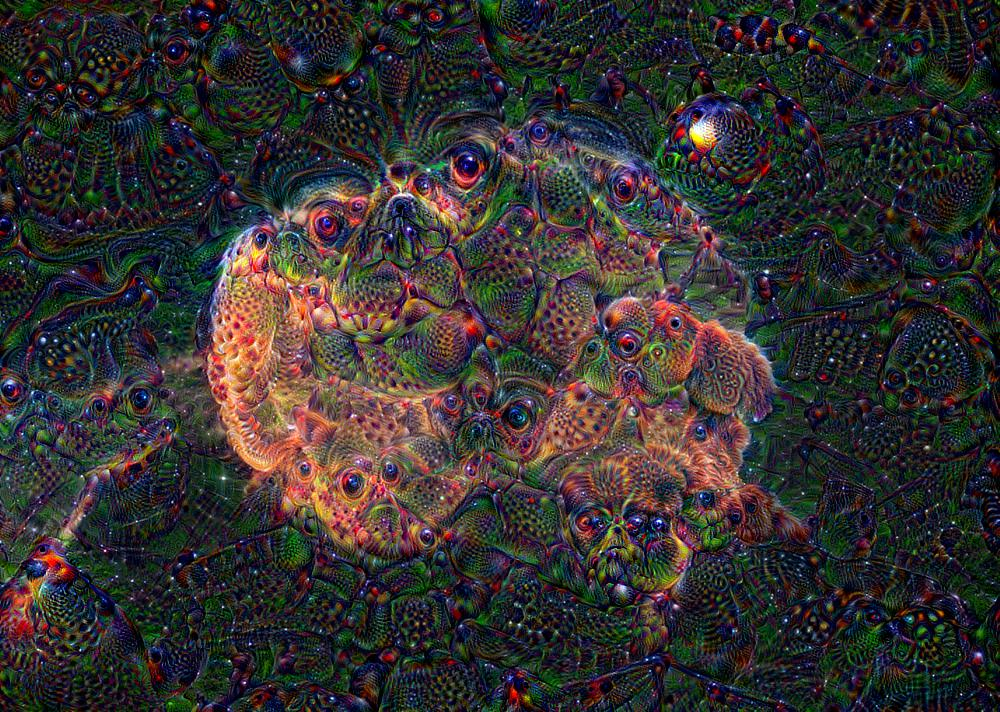

In [32]:
layer = "mixed5b_pool_reduce_pre_relu"
final = render_deepdream(tf.square(T(layer)), img1)

We can also use TensorBoard to visualize the full graph to understand better how these different layers relate to each other. Most of the code in the next section just makes the graph look a little bit cleaner.

In [ ]:

# Helper functions for TF Graph visualization
from IPython.display import  HTML
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.compat.v1.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = tf.compat.as_bytes("<stripped %d bytes>"%size)
    return strip_def
  
def rename_nodes(graph_def, rename_func):
    res_def = tf.compat.v1.GraphDef()
    for n0 in graph_def.node:
        n = res_def.node.add() 
        n.MergeFrom(n0)
        n.name = rename_func(n.name)
        for i, s in enumerate(n.input):
            n.input[i] = rename_func(s) if s[0]!='^' else '^'+rename_func(s[1:])
    return res_def
  
def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
  
    iframe = """
        <iframe seamless style="width:800px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))
tmp_def = rename_nodes(graph_def, lambda s:"/".join(s.split('_',1)))
tmp_def

In [ ]:

# Visualizing the network graph. Be sure expand the "mixed" nodes to see their 
# internal structure. We are going to visualize "Conv2D" nodes.
show_graph(graph_def)